
**Phase-type distributions** describe *waiting times* in Markov jump processes - systems that move through multiple states on its the way to a final (absorbing) state. A Markov jump process is a system that exists in one of several *states* at any moment and randomly *jumps* between states at rates determined only by the present state. Such as

- Multi-step reaction kinetics: Time of chemical reactions proceeding through multiple intermediate states.
- Bank Loan Risk Assessment: Time to default through credit states of corporate borrowers.
- Protein Interaction Networks: Time from stimulus to transcriptional response in signal transduction cascades
- Network information: Time for gossip to traverse a social network.
- River and Drainage Capacity: Time for water to reach the sea through one of many routes.
- RNA transcript length: Number of nucleotides spanning exons included by the RNA splicing machinery. 
- Genetic diversity: Differences between DNA sequences accumulated along the ancestral lineages eventually coalescing into a single ancestor.

Fortunately, you do not need to know anything about phase-type distributions to use Phasic; You can:

1. Dest assured that they are well understood by mathematicians.
2. Forget that the computational complexity of their  matrix formulation made them useless in practice.
3. Enjoy that when formulated as graphs of interconnected states, they become both intuitive and computationally useful.


## Your First Model


## Your First Phase-Type Model

Let's build the simplest possible model: exponential waiting time. Imagine a single stage process—you start, wait some random amount of time, then finish.

In the example below, we construct a graph representing this simple process. This is done using the Python API by first creating a `Graph` object that will hold all our states. The `state_length` parameter specifies how many integers we need to describe each state (here just 1). Every graph automatically includes a starting vertex, which we retrieve, and then we create an absorbing state (the end point) using `find_or_create_vertex()`. Finally, we connect these states with an edge whose weight represents the transition rate:

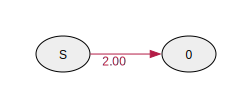

In [1]:
#| label: fig-exponential
#| fig-cap: "Simple exponential distribution model"
#| column: margin

import phasic as ptd
ptd.set_theme("light")

# Create a graph with 1-dimensional states
graph = ptd.Graph(state_length=1)

# Get the starting state (automatically created)
start = graph.starting_vertex()

# Create the absorbing state (represents completion)
end = graph.find_or_create_vertex([0])

# Add transition with rate 2.0
start.add_edge(end, weight=2.0)

graph.plot()

This models an exponential distribution with rate 2.0. Once we've constructed the graph, we can compute moments directly. The expected waiting time is 1/rate = 0.5, which we verify by calling `expected_waiting_time()` on the graph:

In [2]:
# Compute expected waiting time
expectation = graph.expected_waiting_time()[0]
print(f"Expected time: {expectation}")  # 0.5

Expected time: 0.0


INFO: building reward compute graph...


## Computing Distributions

Once you've built a model, you can compute probability distributions. Below we demonstrate how to evaluate both the probability density function (PDF) and cumulative distribution function (CDF) at specific time points. The `pdf()` method returns the probability density at a given time, while `cdf()` returns the probability that the waiting time is less than or equal to that time:


In [3]:
import numpy as np

# Evaluate PDF (probability density function)
time = 1.0
density = graph.pdf(time)
print(f"PDF at t=1: {density}")

# Evaluate CDF (cumulative distribution)
prob = graph.cdf(time)
print(f"P(T ≤ 1) = {prob}")

# Or evaluate at multiple times
times = np.linspace(0, 5, 100)
pdf_values = np.array([graph.pdf(t) for t in times])
cdf_values = np.array([graph.cdf(t) for t in times])

PDF at t=1: 0.0
P(T ≤ 1) = 2.0


Beyond computing distributions analytically, you can also draw random samples from the distribution. This is useful for Monte Carlo simulation or for validating your model by comparing sample statistics to theoretical moments:

In [4]:
# Sample 1000 waiting times
samples = graph.sample(1000)
print(samples[:10])  # Show first 10 samples
print(f"Sample mean: {np.mean(samples):.3f}")

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Sample mean: 0.000


## Multi-Stage Processes

Real processes often have multiple stages. In the example below, we construct a three-stage process known as an Erlang distribution. The process must pass through three consecutive states before reaching absorption. We create each state using `find_or_create_vertex()` with different state labels, then connect them sequentially using `add_edge()`. Each transition has the same rate (1.0), so the expected time in each stage is 1.0, and the total expected time is the sum across all stages:

Expected time: 2.0


INFO: building reward compute graph...


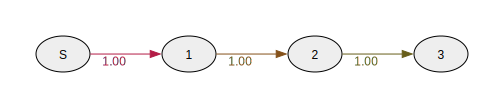

In [5]:
#| label: fig-erlang
#| fig-cap: "Three-stage Erlang distribution model"
#| column: margin

graph = ptd.Graph(state_length=1)

# Create states: start (0) → stage1 → stage2 → end
start = graph.starting_vertex()
stage1 = graph.find_or_create_vertex([1])
stage2 = graph.find_or_create_vertex([2])
end = graph.find_or_create_vertex([3])

# Connect them with rates
start.add_edge(stage1, weight=1.0)
stage1.add_edge(stage2, weight=1.0)
stage2.add_edge(end, weight=1.0)

# Expected time is sum of stage times: 1/1 + 1/1 + 1/1 = 3
expectation = graph.expected_waiting_time()[0]
print(f"Expected time: {expectation}")  # 3.0

graph.plot()

## Branching Processes

Processes can also branch—from one state, you might go to different next states with different probabilities. Below we extend the previous examples to include branching. We create two alternative paths from the starting state: a fast path and a slow path. The process randomly chooses one path at the start. When multiple edges leave a state, the relative rates determine the branching probabilities (3.0/(3.0+1.0) = 75% for the fast path). We then call `normalize()` to convert all transition rates into proper probabilities, ensuring they sum to one at each state:

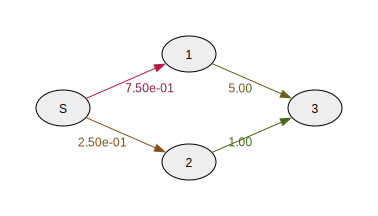

In [6]:
#| label: fig-branching
#| fig-cap: "Branching process with fast and slow paths"
#| column: margin

graph = ptd.Graph(state_length=1)
start = graph.starting_vertex()

# Two possible paths
fast_path = graph.find_or_create_vertex([1])
slow_path = graph.find_or_create_vertex([2])
end = graph.find_or_create_vertex([3])

# Branch at start (rates determine probabilities)
start.add_edge(fast_path, weight=3.0)  # 75% probability
start.add_edge(slow_path, weight=1.0)  # 25% probability

# After normalization, fast path completes quickly, slow path slowly
graph.normalize()  # Convert rates to probabilities
fast_path.add_edge(end, weight=5.0)
slow_path.add_edge(end, weight=1.0)

graph.plot()

## Rewards: Tracking Accumulated Values

Often you want to track not just *when* something happens, but *how much* accumulates along the way. **Rewards** let you associate values with states. In the example below, we construct a simple three-stage process and then assign different reward values to each state. These rewards might represent costs, accumulated mutations, or any other quantity that accrues over time. By passing the reward array to `expected_waiting_time()`, we compute the expected accumulated reward—the sum of rewards weighted by the time spent in each state:

Expected cost: 7.0


INFO: building reward compute graph...


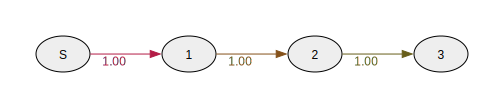

In [7]:
#| label: fig-rewards
#| fig-cap: "Three-stage process with reward values"
#| column: margin

graph = ptd.Graph(state_length=1)
start = graph.starting_vertex()
state1 = graph.find_or_create_vertex([1])
state2 = graph.find_or_create_vertex([2])
end = graph.find_or_create_vertex([3])

start.add_edge(state1, weight=1.0)
state1.add_edge(state2, weight=1.0)
state2.add_edge(end, weight=1.0)

# Assign rewards to each state
# For example: cost per unit time spent in each state
rewards = np.array([0.0, 2.0, 5.0, 0.0])  # One reward per vertex

# Expected accumulated reward (weighted waiting time)
expected_reward = graph.expected_waiting_time(rewards)[0]
print(f"Expected cost: {expected_reward}")

graph.plot()

This computes the expected value of the accumulated reward—essentially the weighted sum of time spent in each state. Rewards are fundamental for working with multivariate phase-type distributions where you track multiple quantities simultaneously.

## Discrete Phase-Type: Counting Steps

Sometimes you want to count **steps** rather than measure time. For example, "how many jumps until absorption?" instead of "how long until absorption?". These are **discrete phase-type distributions** and are easily produced from continuous ones. To learn more see @cont_vs_discrete.


## Building Complex State Spaces

For larger models, manually creating vertices becomes tedious. You can use a **callback function** to define transitions programmatically. In the example below, we demonstrate this with a simple coalescent model from population genetics. Instead of manually creating vertices and edges, we define a function `build_transitions()` that specifies what transitions are possible from any given state. The function receives a state (represented as a list of integers) and returns a list of possible transitions, each specified as a tuple of (next_state, rate).

When we pass this callback to `Graph()`, the library automatically explores the state space: it starts with an empty state, calls the function to find the next states, then recursively calls it for each new state discovered. This approach is particularly powerful for models where the state space structure is complex or depends on parameters:

Expected coalescence time: 1.0


INFO: building reward compute graph...


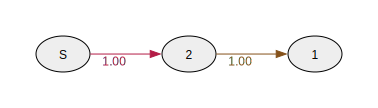

In [8]:
#| label: fig-coalescent-callback
#| fig-cap: "Coalescent model built using callback function"
#| column: margin

def build_transitions(state):
    """Define transitions from a given state."""
    if not state.size:  # Starting state
        return [([2], 1.0)]  # Start with 2 lineages

    transitions = []
    n = state[0]

    if n > 1:
        # Coalescence rate: n choose 2
        rate = n * (n - 1) / 2
        transitions.append(([n - 1], rate))

    return transitions

# Build graph automatically
graph = ptd.Graph(callback=build_transitions)

# Compute expected coalescence time
expectation = graph.expected_waiting_time()[0]
print(f"Expected coalescence time: {expectation}")

graph.plot()

The library automatically builds the state space by repeatedly calling your function for each newly discovered state. This callback-based construction is the foundation for building large, complex models efficiently.

## Next Steps

You now understand the basics:

- **Phase-type distributions** model waiting times in multi-stage processes
- **States** are connected by **transitions** with rates or probabilities
- **Expected waiting times** tell you average completion times
- **Rewards** let you track accumulated values
- **Discrete phase-type** counts steps instead of time

From here, you can:

- Explore [state space construction](state_space_construction.ipynb) for complex models
- Learn about [reward transformations](../api/Graph.html#reward_transform) for computing moments
- Use [JAX integration](../advanced/jax_integration.qmd) for automatic differentiation
- Apply [SVGD](../advanced/svgd.ipynb) for Bayesian parameter inference

The key insight: by representing processes as graphs of states and transitions, phase-type distributions provide a flexible framework for modeling virtually any waiting time distribution—and this library makes computing with them fast and efficient.

## Reference

For the mathematical foundation and graph algorithms, see:

[Røikjer et al. (2022)](https://doi.org/10.1007/s11222-022-10150-8). Graph-based algorithms for phase-type distributions. *Statistics and Computing*, 32, 91.
